# Pattern sampling on Amazon reviews

In [ ]:
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
from decimal import Decimal

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We only load data that have been pre-treated. To find the pre-treatment we used, read the report and go to our github page: [Amazaon EDA](https://github.com/ElouanV/amazon_eda)

To manipulate very large numbers, we will use the Decimal object when we are dealing with weigth.

In [ ]:
# Load data between 2026 and 2018
df = pd.read_csv('drive/MyDrive/Sports_and_Outdoors_5_2016_2018.csv')
df = df.dropna()
df = df[['reviewerID', 'asin']]
df = df.drop_duplicates()
df = df.groupby('reviewerID')['asin'].apply(list).reset_index(name='items')
df['items'] = df['items'].apply(lambda x: list(set(x)))
df

,reviewerID,items
0,A0001528BGUBOEVR6T5U,[B012ZIGVXE]
1,A0024836TBQJ1WBE4VDY,"[B001GH4WD2, B001CXFHKC, B01AISP1KW, B0179XHY3..."
2,A0029274J35Q1MYNKUWO,"[B00HTN4R6O, B000PD6QJ6, B00162POP2, B00162LR6..."
3,A0036244LFNO78OM4135,"[B003BLP0I2, B00R7AGTKG, B01BE07ZKW, B001N3MKT..."
4,A0065811S4ANKB4TYHII,"[B004R5V47C, B0002IMP94, B00OHJDDPY]"
...,...,...
262046,AZZW780H8VJ8N,"[B001O2PKGM, B01E4YVCOA, B01AAGVWJG, B000P431B..."
262047,AZZYI1EW1WY3M,"[B000YXBC5U, B000MBNPHC, B00LUMKP34, B00CPJ546..."
262048,AZZYVIRS854I7,"[B0159JSKYE, B00318CLTG, B00ZK4ZU1U, B006NZ65L4]"
262049,AZZYW4YOE1B6E,"[B002WN91Q2, B00HN47G1M, B005YPK9SY, B013CVSXF2]"


Here we compute the preprocessing step of the method, computing the weights of transactions

In [ ]:
df['len'] = df['items'].apply(lambda x: len(x))
# Add weight to rows according to the number of combinations in the items list (2** len(items))
weight = df['len'].apply(lambda x: Decimal(2)**Decimal(x))
max(weight)

Decimal('1.197262141301475670592458615E+52')

In [ ]:
cumweight = weight.cumsum()
cumweight.iloc[-1]

Decimal('1.197262161372147454742507159E+52')

In [ ]:
np.mean(df['len'])

5.015893852723325

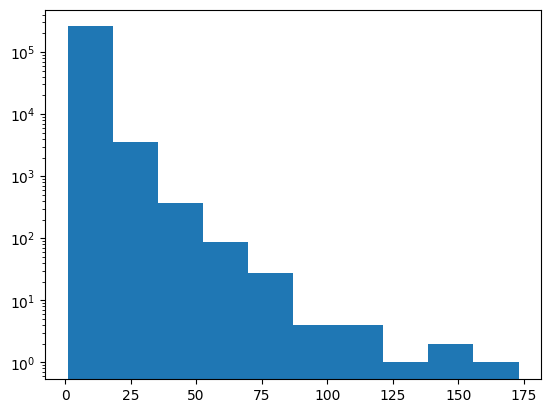

In [ ]:
plt.hist(df['len'])
plt.yscale('log')

We can observe a long tail distribution for the length of transactions in our dataset.

We define then the sampling function, without length restriction:

In [ ]:
import random as rd

def binary_search(list, element, first=0, last=None):
    if last is None:
        last = len(list) - 1
    while first <= last:
        mid = (first + last) // 2
        if list[mid] == element:
            return mid  # Element found, return its index
        elif element < list[mid]:
            last = mid - 1
        else:
            first = mid + 1
    return first  # Element not found, return the index where it should be inserted


def sample(transactions, weight, cumsum_weight):
    """
    Sample a pattern from the transactional database according to its frequency
    :param transactions: transactional database
    :return: a pattern
    """
    # Generate a random number between 0 and the sum of the weights
    r = Decimal(np.random.random()) * cumsum_weight.iloc[-1]
    # Find the index of the element in the cumulative weight list using a binary search
    index = binary_search(cumweight.tolist(), r)
    # Sample item in the transaction to create a pattern
    pattern = []
    for item in df['items'][index]:
        if rd.Random().random() <= 0.5:
            pattern.append(item)
    return pattern

We sample 1000 patterns with this method:

In [ ]:
import time

In [ ]:
# Generate 1000 patterns
patterns = []
start = time.time()
for i in range(100_000):
    patterns.append(sample(df, weight, cumweight))
end = time.time()
print(f'Took {end-start} seconds for 100 000 itertations')

Took 1476.3289139270782 seconds for 100 000 itertations


(array([9.0000e+00, 2.7000e+01, 1.4100e+02, 2.8800e+02, 1.1680e+03,
        3.1400e+03, 6.3800e+03, 6.9110e+03, 1.4251e+04, 1.7600e+04,
        1.7717e+04, 1.0126e+04, 1.1116e+04, 6.5810e+03, 2.9500e+03,
        8.7200e+02, 5.3900e+02, 1.4600e+02, 3.2000e+01, 6.0000e+00]),
 array([ 59.  ,  61.75,  64.5 ,  67.25,  70.  ,  72.75,  75.5 ,  78.25,
         81.  ,  83.75,  86.5 ,  89.25,  92.  ,  94.75,  97.5 , 100.25,
        103.  , 105.75, 108.5 , 111.25, 114.  ]),
 <BarContainer object of 20 artists>)

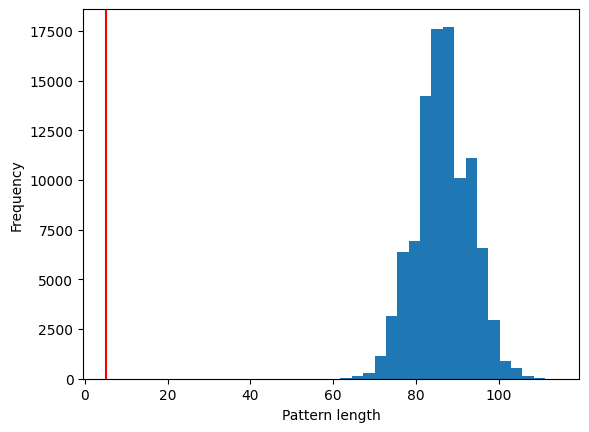

In [ ]:
pattern_len = [len(pattern) for pattern in patterns]
plt.xlabel('Pattern length')
plt.ylabel('Frequency')
plt.axvline(np.mean(df['len']), color='red')
plt.hist(pattern_len, bins=20)

This plot show the length distribution of patterns that have been sampled, with the mean transaction length in red.

We now want to observe the support of sampled patterns:

In [ ]:
# Compute and plot support of 100 patterns
supports = []
for pattern in tqdm(patterns[:100]):
    support = df['items'].apply(lambda x: set(pattern).issubset(set(x))).sum()
    supports.append(support)
print(np.mean(supports))


100%|██████████| 100/100 [01:34<00:00,  1.06it/s]

1.0


In [ ]:
print(np.mean(supports))

1.0


But the mean support is 1 (occurrence), it means that the pattern we extracted is only present in the transaction we draw.

In [ ]:
%timeit sample(df, weight, cumweight)

13.4 ms ± 712 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


To sample one frequent pattern, this method took 15.7ms

# Frequent pattern mining with length restriction

Now, we will try to use a similar method, but with length restriction

We will use the mean transaction length to define our length restriction

In [ ]:
MAX_LEN = 5
MIN_LEN = 1

In [ ]:
def factorial(n):
    if n < 0:
        raise ValueError('n must be positive')
    if n == 0:
        return Decimal(1)
    else:
        return n * factorial(n - 1)

def combination(n, k):
    if n <0 or k<0 or k>n:
        return 0
    return factorial(Decimal(n)) / (factorial(Decimal(k)) * factorial(Decimal(n) - Decimal(k)))

In [ ]:
# Add weight to df
def add_weight(df, min_len, max_len):
    df['weight'] = df['len'].apply(lambda x: np.array([combination(x, k) for k in range(min_len, max_len)]).sum())
    df['cumweight'] = df['weight'].cumsum()
    return df

In [ ]:
df = add_weight(df, MIN_LEN, MAX_LEN)
sum_weight = df['weight'].sum()

In [ ]:
def len_restricted_sampling(df, sum_weight, MIN_LEN, MAX_LEN):
    random_transaction = Decimal(rd.random()) * sum_weight
    transaction_index = binary_search(df['cumweight'], random_transaction)
    transaction = df.iloc[transaction_index]
    # Generate weights array for each combination size
    weights = np.array([combination(len(transaction), k) for k in range(MIN_LEN, MAX_LEN+1)])
    # Get a random index from the weights array
    random_size = Decimal(rd.random()) * weights.sum()
    for i in range(1,len(weights)):
        weights[i] += weights[i-1]
    index = binary_search(weights, random_size)

    # Get the size of the pattern
    size = index + MIN_LEN


    # Draw 'size' random elements from the transaction which is a dataframe row
    if size > transaction['len']:
        if transaction['len'] > MIN_LEN:
            return transaction['items']
        else:
            # If the size of the transaction is to small, retry
            return len_restricted_sampling(df, sum_weight, MIN_LEN, MAX_LEN)
    pattern = rd.sample(transaction['items'], size)
    return pattern

In [ ]:
pattern = len_restricted_sampling(df, sum_weight, MIN_LEN=MIN_LEN, MAX_LEN=MAX_LEN)
print(pattern, '\n', len(pattern))

['B00579GNBE', 'B003V0KHBS', 'B00HTN6F32', 'B000N8JZ0U'] 
 4


In [ ]:
from tqdm import tqdm
# Sample 100000 patterns
patterns = []
patterns_len = []
start = time.time()
for i in tqdm(range(0, 100_000)):
    pattern = len_restricted_sampling(df, sum_weight, MIN_LEN=MIN_LEN, MAX_LEN=MAX_LEN)
    patterns.append(pattern)
    patterns_len.append(len(pattern))
end= time.time()
print(f'Took {end-start} seconds for 100 000 iterations')

100%|██████████| 100000/100000 [00:41<00:00, 2397.69it/s]

Took 41.71341037750244 seconds for 100 000 iterations


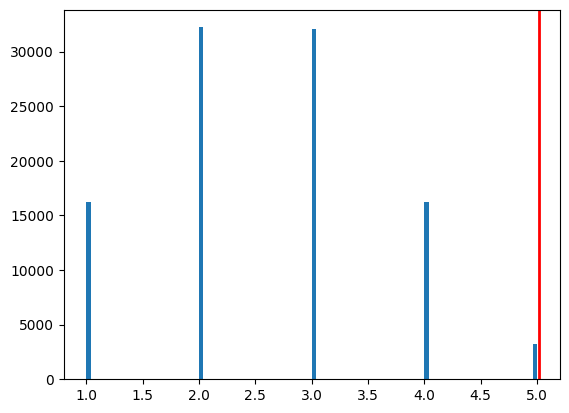

In [ ]:
# Plot the distribution of the pattern length
import matplotlib.pyplot as plt
plt.hist(patterns_len, bins=100)
# Add a vertcal line at the mean
plt.axvline(np.mean(df['len']), color='r', linewidth=2)
plt.show()

Again, we want to see the support of extracted patterns

In [ ]:
# Compute and plot support of 1000 patterns
supports = []
for pattern in tqdm(patterns[:100]):
    support = df['items'].apply(lambda x: set(pattern).issubset(set(x))).sum()
    supports.append(support)
print(np.mean(supports))

100%|██████████| 100/100 [00:32<00:00,  3.11it/s]

29.54


In [ ]:
print(np.mean(supports))

29.54


In [ ]:
%timeit len_restricted_sampling(df, sum_weight, MIN_LEN=MIN_LEN, MAX_LEN=MAX_LEN)

335 µs ± 14.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# High utility pattern mining

In [ ]:
from tqdm import tqdm

# Load data
df = pd.read_csv('drive/MyDrive/Sports_and_Outdoors_5_2016_2018.csv')
df = df.dropna()
df = df[['reviewerID', 'asin', 'overall']]
df = df.drop_duplicates()
# Group by reviewerID and build a list of (asin, overall) tuples
df = df.groupby('reviewerID')[['asin', 'overall']].apply(lambda x: list(zip(x['asin'], x['overall']))).reset_index(name='items')
df['items'] = df['items'].apply(lambda x: list(set(x)))
df

,reviewerID,items
0,A0001528BGUBOEVR6T5U,"[(B012ZIGVXE, 3.0)]"
1,A0024836TBQJ1WBE4VDY,"[(B00AU67NEA, 4.0), (B00E2217I6, 5.0), (B00PRV..."
2,A0029274J35Q1MYNKUWO,"[(B00162POP2, 5.0), (B000PD6QJ6, 5.0), (B0018E..."
3,A0036244LFNO78OM4135,"[(B001N3MKT2, 5.0), (B003BLP0I2, 4.0), (B00R7A..."
4,A0065811S4ANKB4TYHII,"[(B00OHJDDPY, 5.0), (B0002IMP94, 5.0), (B004R5..."
...,...,...
262046,AZZW780H8VJ8N,"[(B000O57MPW, 5.0), (B000P431BG, 5.0), (B00XJ5..."
262047,AZZYI1EW1WY3M,"[(B00DDZGCOW, 5.0), (B01489QOOO, 5.0), (B000MB..."
262048,AZZYVIRS854I7,"[(B00318CLTG, 1.0), (B0159JSKYE, 5.0), (B00ZK4..."
262049,AZZYW4YOE1B6E,"[(B002WN91Q2, 4.0), (B013CVSXF2, 5.0), (B00HN4..."


In [ ]:
# Load metadata
df_meta = pd.read_csv('drive/MyDrive/meta_Sports_and_Outdoors.csv')
print(df_meta.columns)
df_meta = df_meta[['asin', 'price']]
df_meta = df_meta.dropna()
df_meta = df_meta.drop_duplicates()
# Remove $ sign
def is_price(x):
    try:
        float(x)
        return True
    except:
        return False
def remove_dollar(x):
    """
    Parse price column to float
    :param x:
    :return:
    """
    x = x.replace('$', '')
    # Remove space
    x = x.replace(' ', '')
    x = x.replace(',','')
    # If x contains a range, take the mean
    try:
        if '-' in x:
            x = x.split('-')

            return (float(x[0]) + float(x[1])) / 2
        return float(x)
    except:
        return 0
df_meta['price'] = df_meta['price'].apply(remove_dollar)
# Count number of 0

mean_price = df_meta[df_meta['price'] != 0]['price'].mean()
df_meta['price'] = df_meta['price'].apply(lambda x: mean_price if x == 0 else x)

print('Number of 0 in price column: {}'.format(df_meta['price'].apply(lambda x: x == 0).sum()))


Index(['asin', 'title', 'price', 'salesRank'], dtype='object')
Number of 0 in price column: 0


In [ ]:
found = [0,0]
def get_profit(item, profit_db):
    """
    Get the profit of an item
    :param item:
    :param profit_db: dictionary of profit
    :return:
    """
    if item in profit_db:
        found[0] += 1
        return Decimal(profit_db[item])
    else:
        found[1] +=1
        return Decimal(0)

In [ ]:
def u(pattern, transaction, profit_db):
    """
    Compute the utility of a pattern in a transaction
    :param pattern:
    :param transaction:
    :return:
    """
    utility = 0
    for item in pattern:
        for i in range(len(transaction)):
            #print('transaciton_u: ', transaction)
            #print('trannsaction_u[i]: ',transaction[i])
            # print("item: ", item)
            if item[0] == transaction[i][0]:
                profit = get_profit(item[0], profit_db)
                quantity = Decimal(transaction[i][1])
                utility += quantity * profit
    return utility

In [ ]:
def U(pattern, transactions, profit_db):
    """
    Compute the utility of a pattern in a transaction
    :param pattern:
    :param transaction:
    :return:
    """
    utility = 0
    for transaction in transactions:
        utility += u(pattern, transaction, profit_db)
    return utility

In [ ]:
def v(l, i, transaction, profit_db, verbose=False):
    if l == 1:
        res = Decimal(0.)
        for j in range(min(i, len(transaction))):
            w = Decimal(transaction[j][1]) * get_profit(transaction[j][0], profit_db)
            if verbose:
                print('q: ', transaction[j])
                print('p: ',get_profit(transaction[j][0], profit_db) )
                print("w: ", w)
            res+= w
        return res
    else:
        if verbose:
            print("Cobination: ",combination(i-1, l-1))
            print('v: ', v(1,i,transaction, profit_db))
        return combination(i-1, l-1) * v(1, i, transaction, profit_db)

def f(l, nu, M):
    return Decimal(1/l) if nu <= l <= M else Decimal(0)

In [ ]:
# Build a profit dictionary
profit_db = {}
for id, row in tqdm(df_meta.iterrows()):
    profit_db[row['asin']] = row['price']

403027it [02:34, 2614.56it/s]


In [ ]:
def jump_dichotomic_search(alpha, l, pattern_utility, transaction, profit_db):
    """
    Find i so that alpha is between binf and bsup
    :param alpha:
    :param l:
    :param pattern_utility:
    :param transaction:
    :param profit_db:
    :param binf:
    :param bsup:

    :return:
    """
    i = len(transaction) // 2
    i_inf = 0
    i_sup = len(transaction) - 1
    while True:
        if i == i_inf or i == i_sup or i_sup - i_inf == 1:
            return i
        if alpha < v(l, i, transaction, profit_db) + combination(i, l) * pattern_utility:
            i_sup = i
            i = i_inf + (i_sup - i_inf) // 2
        elif alpha > v(l, i, transaction, profit_db) + combination(i, l) * pattern_utility:
            i_inf = i
            i = i_inf + (i_sup - i_inf) // 2
        else:
            return i

In [ ]:
# Preprocessing of QPlus, assigning weight to transaction, once it's done we can perform as sampling as we need
import time
def preprocessing(transaction, nu,M, profit_db):
    w = 0
        # if l is inf
    if M == np.inf:
        return 2**(len(transaction)-1) * sum([item[1]* profit_db[item[0]] for item in transaction])
    else:
        v_1_i = v(1, len(transaction), transaction, profit_db)
        for l in range(nu, M):
            v_l_i = combination(len(transaction)-1, l-1) * v_1_i
            w += v_l_i * f(l , nu, M)
        return w

start = time.time()
weights = []
for transaction in tqdm(df['items']):
    weights.append(preprocessing(transaction, 1, 3, profit_db))
df['weight'] = weights
end = time.time()
print('Preprocessing took: {} seconds'.format(end - start))
df['cumweight'] = df['weight'].cumsum()
print('Found:', found[0])
print('Notfound: ', found[1])

100%|██████████| 262051/262051 [01:14<00:00, 3519.54it/s]


Preprocessing took: 75.15898299217224 seconds
Found: 1109512
Notfound:  205449


In [ ]:
print(np.max(df['weight']))

3520041.286427845606397113439


In [ ]:
def qplus(df, nu, M, profit_db):
    """
    Sample a pattern from the transactional database according to its utility
    :param df:
    :param nu:
    :param M:
    :return:
    """

    # Sample pattern
    # Draw a transaction t from df proportionally to its weight
    random = Decimal(np.random.random()) * df['weight'].sum()
    index = binary_search(df['cumweight'].tolist(), random)
    transaction = df['items'][index]
    # print('Transaction weight:', df['weight'][index])
    # Draw integer l from nu to M<with a probaility equals to
    length_weight = [v(l, len(transaction), transaction, profit_db) * f(l , nu, M) / df['weight'][index] for l in range(nu, M)]
    # print('len weight: ', length_weight)
    # print('v: ',v(3, len(transaction), transaction, profit_db))
    # print('f: ', f(3, nu, M))
    # print(len(transaction))
    # Normalize length_weightµ
    # print(sum(length_weight))
    length_weight = [w / sum(length_weight) for w in length_weight]
    l = int(np.random.choice(range(nu, M), p=length_weight))
    pattern = []
    j = len(transaction)
    while l > 0:
        #print("l: ", l)
        # print('Transaction:', transaction)
        pattern_utility = U(pattern, df['items'], profit_db)
        # print(type(j))
        # print(type(l))
        alpha = Decimal(np.random.random()) * v(l,j, transaction, profit_db) +combination(j-1, l-1) * pattern_utility
        i = 1
        # print("l: ", l)
        # print("Pattern utility: ", pattern_utility)
        # print("v___: ", v(l, i-1, transaction, profit_db))
        # print('Binf')
        binf = v(l, i-1, transaction, profit_db, verbose=False) + combination(i-1, l) * pattern_utility
        # print('Bsup:')
        bsup = v(l, i, transaction, profit_db, verbose=False) + combination(i, l) * pattern_utility
        i = int(jump_dichotomic_search(alpha, l, pattern_utility, transaction, profit_db))
        # print(binf, bsup)
        # print("i: ",i)
        # print(transaction[i])
        pattern.append(transaction[i])
        l -= 1
        j = i
    return pattern

In [ ]:
utility = U(pattern, df['items'],profit_db)

In [ ]:
print(utility)

10701.27999999999958902208164


In [ ]:
patterns=[]
start = time.time()
for _ in tqdm(range(100)):
    patterns.append(qplus(df, 3,7, profit_db))
end = time.time()
print(f'Took {end-start} seconds for 100 calls')

100%|██████████| 100/100 [05:50<00:00,  3.51s/it]

Took 350.80177092552185 seconds for 100 calls


In [ ]:
Us = []
for pattern in tqdm(patterns):
    Us.append(U(pattern, df['items'], profit_db))
print(f'Mean utility: {np.mean(Us)}')

100%|██████████| 100/100 [02:22<00:00,  1.42s/it]

Mean utility: 133514.0305627134971437719424


In [ ]:
print(f'Mean utility: {np.mean(Us)}')

Mean utility: 133514.0305627134971437719424


In [ ]:
profit_db['B00IJP4HGG']

39.95

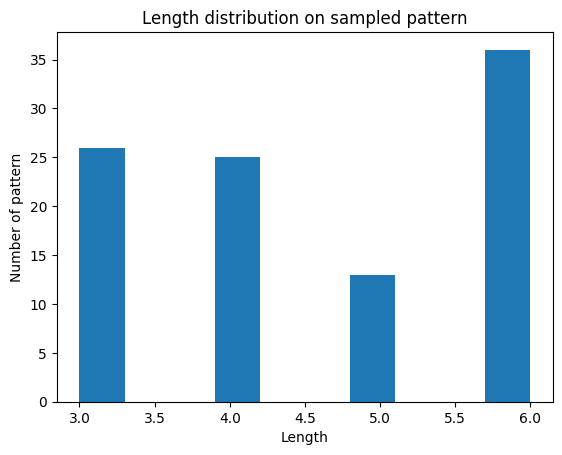

In [ ]:
# Plot the distribution of the pattern length
import matplotlib.pyplot as plt
patterns_len = [len(pattern) for pattern in patterns]
plt.hist(patterns_len)
plt.title('Length distribution on sampled pattern')
plt.xlabel('Length')
plt.ylabel('Number of pattern')
plt.show()

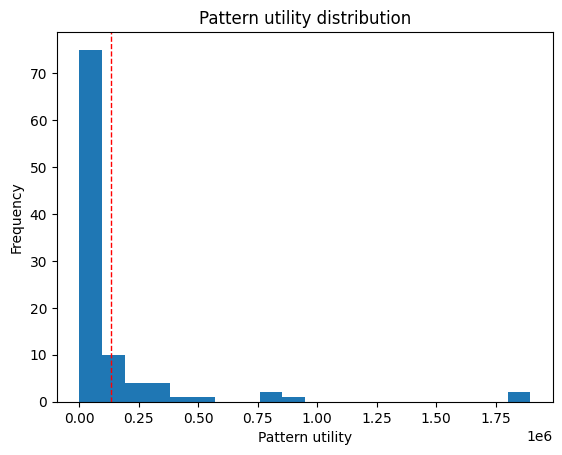

In [ ]:

plt.xlabel('Pattern utility')
plt.ylabel('Frequency')
# Add the mean len of transaction to the plot
plt.axvline(np.mean(Us), color='red', linestyle='dashed', linewidth=1)
plt.hist(Us, bins=20)
plt.title('Pattern utility distribution')
plt.savefig('pattern_utility_distribution.png')